In [92]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [131]:
train = pd.read_csv('C:/Users/y_binna/Desktop/쿠빅2학기/data/ashrae-energy-prediction/train.csv')
weather_train = pd.read_csv('C:/Users/y_binna/Desktop/쿠빅2학기/data/ashrae-energy-prediction/weather_train.csv')
building = pd.read_csv('C:/Users/y_binna/Desktop/쿠빅2학기/data/ashrae-energy-prediction/building_metadata.csv')

In [132]:
weather_train0 = weather_train[weather_train.site_id==0]
building0 = building[building.site_id==0]

In [133]:
mer_data0 = pd.merge(train, weather_train0, on = 'timestamp')
mer_data0 = pd.merge(mer_data0, building0, on = 'building_id')
mer_data0 = mer_data0.set_index('timestamp')
mer_data0.drop(['meter','site_id_x','site_id_y','floor_count'], axis='columns', inplace=True)

In [134]:
mer_data0.head()

,building_id,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use,square_feet,year_built
timestamp,,,,,,,,,,,,
2016-01-01 00:00:00,0,0.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,Education,7432,2008.0
2016-01-01 01:00:00,0,0.0,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,Education,7432,2008.0
2016-01-01 02:00:00,0,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,Education,7432,2008.0
2016-01-01 03:00:00,0,0.0,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,Education,7432,2008.0
2016-01-01 04:00:00,0,0.0,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,Education,7432,2008.0


In [135]:
mer_data0 = mer_data0.fillna(method='ffill')
mer_data0 = mer_data0.fillna(method='bfill')
mer_data0.head()

,building_id,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use,square_feet,year_built
timestamp,,,,,,,,,,,,
2016-01-01 00:00:00,0,0.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,Education,7432,2008.0
2016-01-01 01:00:00,0,0.0,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5,Education,7432,2008.0
2016-01-01 02:00:00,0,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,Education,7432,2008.0
2016-01-01 03:00:00,0,0.0,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,Education,7432,2008.0
2016-01-01 04:00:00,0,0.0,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,Education,7432,2008.0


In [137]:
values = mer_data0.values

In [138]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [140]:
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values[:,9] = encoder.fit_transform(values[:,9])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[12,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var2(t)
1,0.0,0.0,0.677326,0.666667,0.840000,0.000000,0.725132,0.000000,0.000000,0.0,0.014675,0.833336,0.0
2,0.0,0.0,0.659884,0.666667,0.871429,0.000000,0.738222,0.194444,0.097403,0.0,0.014675,0.833336,0.0
3,0.0,0.0,0.613372,0.222222,0.871429,0.002907,0.738222,0.000000,0.000000,0.0,0.014675,0.833336,0.0
4,0.0,0.0,0.563954,0.222222,0.857143,0.002907,0.735603,0.000000,0.000000,0.0,0.014675,0.833336,0.0
5,0.0,0.0,0.531977,0.222222,0.840000,0.000000,0.732986,0.694444,0.168831,0.0,0.014675,0.833336,0.0


In [141]:
values = reframed.values
n_train_hours = 300*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7200, 1, 12) (7200,) (1069461, 1, 12) (1069461,)


In [142]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                   validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7200 samples, validate on 1069461 samples
Epoch 1/50
 - 11s - loss: 0.0073 - val_loss: 0.0112
Epoch 2/50
 - 13s - loss: 0.0024 - val_loss: 0.0160
Epoch 3/50
 - 13s - loss: 0.0018 - val_loss: 0.0148
Epoch 4/50
 - 11s - loss: 0.0012 - val_loss: 0.0145
Epoch 5/50
 - 11s - loss: 0.0019 - val_loss: 0.0200
Epoch 6/50
 - 14s - loss: 0.0019 - val_loss: 0.0153
Epoch 7/50
 - 14s - loss: 0.0014 - val_loss: 0.0151
Epoch 8/50
 - 11s - loss: 0.0012 - val_loss: 0.0147
Epoch 9/50
 - 10s - loss: 0.0011 - val_loss: 0.0138
Epoch 10/50
 - 16s - loss: 0.0018 - val_loss: 0.0148
Epoch 11/50
 - 12s - loss: 0.0012 - val_loss: 0.0146
Epoch 12/50
 - 15s - loss: 0.0011 - val_loss: 0.0155
Epoch 13/50
 - 12s - loss: 0.0015 - val_loss: 0.0154
Epoch 14/50
 - 15s - loss: 0.0015 - val_loss: 0.0119
Epoch 15/50
 - 28s - loss: 0.0015 - val_loss: 0.0153
Epoch 16/50
 - 14s - loss: 0.0010 - val_loss: 0.0121
Epoch 17/50
 - 13s - loss: 7.5191e-04 - val_loss: 0.0151
Epoch 18/50
 - 13s - loss: 0.0016 - val_loss: 0.0140


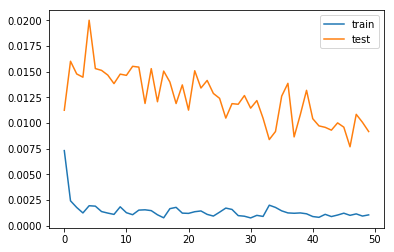

In [143]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [144]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.244
